### Derived from the tutorial avalible [HERE](https://geographicdata.science/book/data/ghsl/build_ghsl_extract.html)

### GHSL extract

This dataset contains an extract from the [2015 GHSL Pop](https://human-settlement.emergency.copernicus.eu/download.php?ds=pop) for the area of Sao Palo (Brazil) and Bacelona (Spain).

Boundry deliniation for the urban aras relies on the [Functional Urban Areas](https://ec.europa.eu/jrc/en/publication/ghsl-oecd-functional-urban-areas) by the GHSL-OECD

In [42]:
import geopandas
import rioxarray
import contextily
import datashader as ds
import matplotlib.pyplot as plt

#### Pull down FUAs

The file with all of the Functional Urban Areas is
avalable at:

In [43]:
url = ("https://jeodpp.jrc.ec.europa.eu/ftp/"\
       "jrc-opendata/GHSL/"\
       "GHS_FUA_UCDB2015_GLOBE_R2019A/V1-0/"\
       "GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.zip"
      )

From here we can uncompress and read the archive on-the-fly with geopandas:

In [44]:
p = f"zip+{url}!GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg"
fuas = geopandas.read_file(p)
sao_paulo = fuas.query("eFUA_name == 'São Paulo'").to_crs("EPSG:4326")
#barcelona = fuas.query("eFUA_name == 'Barcelona'").to_crs("EPSG:4326")
#los_angeles = fuas.query("eFUA_name == 'Los Angeles'").to_crs("EPSG:4326")

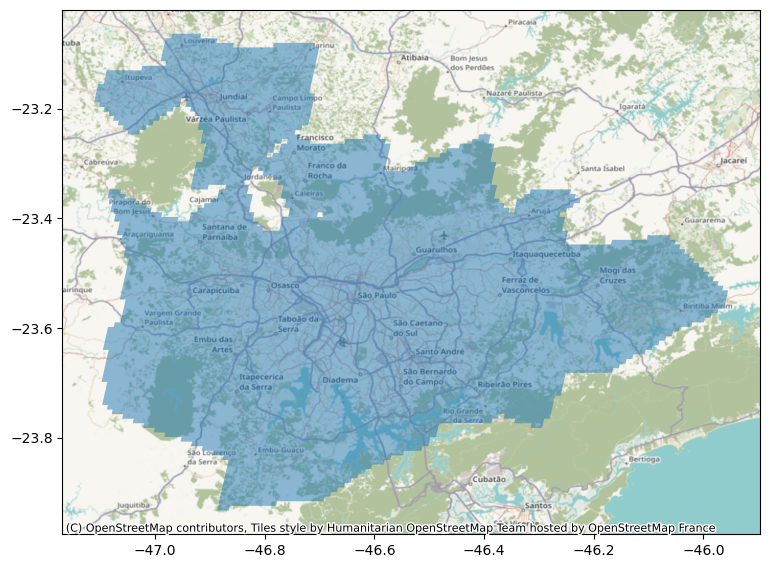

In [45]:
# Sao Paulo
ax = sao_paulo.plot(alpha=0.5, figsize=(9, 9))
contextily.add_basemap(ax, crs=sao_paulo.crs);

# Barcelona
# ax = barcelona.plot(alpha=0.5, figsize=(9, 9))
# contextily.add_basemap(ax, crs=barcelona.crs);

#Chicago
# ax = los_angeles.plot(alpha=0.5, figsize=(9, 9))
# contextily.add_basemap(ax, crs=los_angles.crs);

#### Pull down population data

In [47]:
#Sao_Paulo 100 m
url=("https://jeodpp.jrc.ec.europa.eu/ftp/"\
     "jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/"\
     "GHS_POP_E2000_GLOBE_R2023A_54009_100/V1-0"\
     "/tiles/"\
     "GHS_POP_E2000_GLOBE_R2023A_54009_100_V1_0_R12_C14.zip"    
    )

#Sao_Paulo 1000 m
# url = ("https://jeodpp.jrc.ec.europa.eu/ftp/"\
#       "jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/"\
#       "GHS_POP_E2020_GLOBE_R2023A_54009_1000/V1-0/"\
#       "tiles/"\
#       "GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R12_C14.zip"
#      )

# Barcelona
# url=("https://jeodpp.jrc.ec.europa.eu/ftp/"\
#      "jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/"\
#      "GHS_POP_E2020_GLOBE_R2023A_54009_100/V1-0"\
#      "/tiles/"\
#      "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C19.zip" 
#     )

# Los Angeles
# url = ("https://jeodpp.jrc.ec.europa.eu/ftp/"\
#        "jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/"\
#        "GHS_POP_E2000_GLOBE_R2023A_54009_100/V1-0/"\
#        "tiles/"\
#        "GHS_POP_E2000_GLOBE_R2023A_54009_100_V1_0_R5_C8.zip"
#       )

From here we can uncompress and read the data with xarray:

In [49]:
%%time
# Sao_Paulo
p = f"zip+{url}!GHS_POP_E2000_GLOBE_R2023A_54009_100_V1_0_R12_C14.tif" 
#p = f"zip+{url}!GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R12_C14.tif" 

# Barcelona
#p = f"zip+{url}!GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R5_C19.tif"

#Los Angeles
#p = f"zip+{url}!GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C8.tif" 

ghsl = rioxarray.open_rasterio(p)
ghsl


CPU times: user 19.6 ms, sys: 0 ns, total: 19.6 ms
Wall time: 1.64 s


<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 800MB
[100000000 values with dtype=float64]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -5.041e+06 -5.041e+06 ... -4.041e+06
  * y            (y) float64 80kB -2e+06 -2e+06 -2e+06 ... -3e+06 -3e+06 -3e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -200.0
    scale_factor:   1.0
    add_offset:     0.0

In [51]:
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.raster(ghsl.where(ghsl>0).sel(band=1))

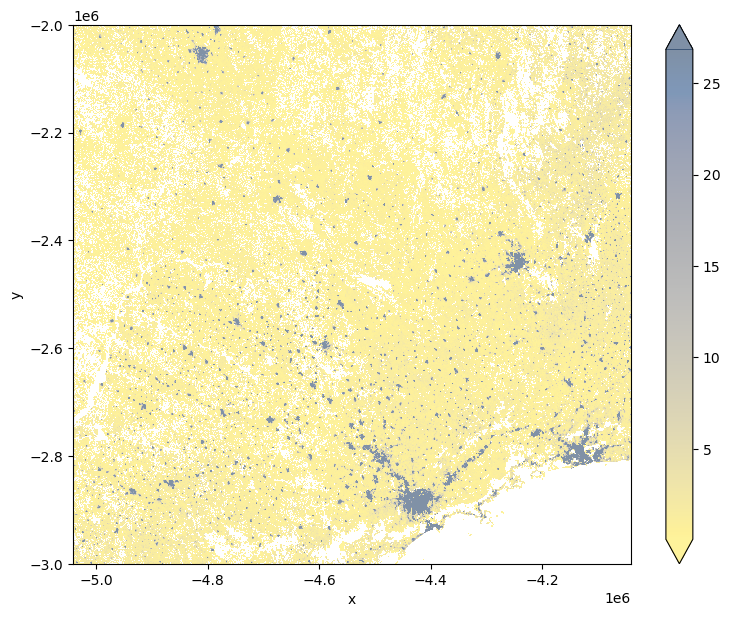

In [52]:
fig, ax = plt.subplots(1, figsize=(9,7))
agg.plot.imshow(ax=ax, alpha=0.5, cmap="cividis_r", robust=True)


#### Extraction

To clip what we need from gshl based on the FUA we selected:

In [53]:
# --- Sao Paulo
# Ensure you have the correct geometry
geometry = sao_paulo.to_crs(ghsl.rio.crs).geometry.iloc[0]

# If geometry is not already a list, wrap it in a list
if not isinstance(geometry, (list, tuple)):
    geometry = [geometry]

# Now use the geometry in the clip method
ghsl_sp = ghsl.rio.clip(geometry)
ghsl_sp


# --- Barcelona 
# Ensure you have the correct geometry
# geometry = barcelona.to_crs(ghsl.rio.crs).geometry.iloc[0]

# # If geometry is not already a list, wrap it in a list
# if not isinstance(geometry, (list, tuple)):
#     geometry = [geometry]

# # Now use the geometry in the clip method
# ghsl_ba = ghsl.rio.clip(geometry)
# ghsl_ba



# --- Los Angeles
#Ensure you have the correct geometry
# geometry = los_angeles.to_crs(ghsl.rio.crs).geometry.iloc[0]

# # If geometry is not already a list, wrap it in a list
# if not isinstance(geometry, (list, tuple)):
#     geometry = [geometry]

# # Now use the geometry in the clip method
# ghsl_la = ghsl.rio.clip(geometry)
# ghsl_la


<xarray.DataArray (band: 1, y: 1040, x: 1170)> Size: 10MB
array([[[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 9kB -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06
  * y            (y) float64 8kB -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -200.0

Finally we can write to a GeoTiff File: 

In [55]:
out_p = "./data/ghsl_sao_paulo_100m_2020.tif"# Sao Paulo
! rm $out_p
ghsl_sp.rio.to_raster(out_p)


#out_p = "./data/ghsl_barcelona.tif_2020"# Barcelona
# ! rm $out_p
# ghsl_ba.rio.to_raster(out_p)


#out_p = "./data/ghsl_los_angles_2000.tif"# Los Angeles
# ! rm $out_p
# ghsl_la.rio.to_raster(out_p)

In [37]:
! rio cogeo validate ghsl_sao_paulo.tif


Usage: rio [OPTIONS] COMMAND [ARGS]...
Try 'rio --help' for help.

Error: No such command 'cogeo'.
